In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# User Inputs

datpath = "../../CESM_data/Metrics/Ablation_Study/"
outpath = "../../CESM_data/Figures/"
expnames = ["ResNet50","EfficientNet-B7-NS","ResNet50 + LSTM","EfficientNet-B7-NS + LSTM","Simple CNN","ResNet50 + GRU"]
leads = np.arange(0,25,3)


In [3]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

In [4]:
%%time
resolution='2deg'
nmembers=40

# Calculate AMV Index Autocorrleation

# Load in data
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_Ann.npy' % (resolution)).astype(np.float32)
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))

# Calculate Autocorrelation
tstep = 86
lags  = 25

sst_ensemble = calc_AMV_index('NAT',sst_normed[:,:,:,:],lat,lon)
sst_lagged_corr = np.zeros((nmembers,lags))

for lead in range(lags):
    sst_lead = sst_ensemble[:,lead:]
    sst_lag = sst_ensemble[:,0:tstep-lead]
    #sss_lag = sss_ensemble[:,0:tstep-lead]

    for ien in range(nmembers):
        sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]    
sst_auto = sst_lagged_corr.copy()



CPU times: user 175 ms, sys: 61.5 ms, total: 236 ms
Wall time: 253 ms


In [5]:
# Load in ResNet50 results
trainloss = []
testloss  = []
testcorr  = []
yvalpred  = []
yvallab   = []

# resnet50
fn    = 'leadtime_testing_ALL_Ann244pix_NAT_resnet50_nepoch20_nens40_lead24.npz'
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'][:,::3])
testloss.append(fload['test_loss'][:,::3])
testcorr.append(fload['test_corr'][::3])
yvalpred.append(fload['yvalpred'][::3])
yvallab.append(fload['yvallabels'][::3])




['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']
train_loss is of shape: (20, 25)
test_loss is of shape: (20, 25)
test_corr is of shape: (25,)
yvalpred is of shape: (25,)
yvallabels is of shape: (25,)


In [6]:
# Load in efficientnet results

fn    = 'leadtime_testing_ALL_Ann244pix_NAT_tf_efficientnet_b7_ns_nepoch20_nens40_20-lead08.npz'
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'])
testloss.append(fload['test_loss'])
testcorr.append(fload['test_corr'])
yvalpred.append(fload['yvalpred'])
yvallab.append(fload['yvallabels'])


['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']
train_loss is of shape: (20, 9)
test_loss is of shape: (20, 9)
test_corr is of shape: (9,)
yvalpred is of shape: (9,)
yvallabels is of shape: (9,)


In [7]:
# Load RN50-LTSM results


fn    = 'leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_LSTM_sqlen30_leadnum24.npz'
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'])
testloss.append(fload['test_loss'])
testcorr.append(fload['test_corr'])
yvalpred.append(fload['y_pred_val'])
yvallab.append(fload['y_valdt'])


['train_loss', 'test_loss', 'test_corr', 'y_pred_val', 'y_valdt']
train_loss is of shape: (20, 9)
test_loss is of shape: (20, 9)
test_corr is of shape: (9,)
y_pred_val is of shape: (456,)
y_valdt is of shape: (456,)


In [8]:
# Load ENB7-LTSM results
fn = "leadtime_testing_ALL_Ann224pix_NAT_tf_efficientnet_b7_ns_nepoch20_nens40_lead08_LSTM_sqlen30_leadnum24.npz"
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'])
testloss.append(fload['test_loss'])
testcorr.append(fload['test_corr'])
yvalpred.append(fload['y_pred_val'])
yvallab.append(fload['y_valdt'])

['train_loss', 'test_loss', 'test_corr', 'y_pred_val', 'y_valdt']
train_loss is of shape: (20, 9)
test_loss is of shape: (20, 9)
test_corr is of shape: (9,)
y_pred_val is of shape: (456,)
y_valdt is of shape: (456,)


In [12]:
# Load Simple CNN

fn = "leadtime_testing_ALL_Ann224pix_NAT_simplecnn_nepoch20_nens40_lead08.npz"
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'])
testloss.append(fload['test_loss'])
testcorr.append(fload['test_corr'])
yvalpred.append(fload['yvalpred'])
yvallab.append(fload['yvallabels'])

['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']
train_loss is of shape: (20, 9)
test_loss is of shape: (20, 9)
test_corr is of shape: (9,)
yvalpred is of shape: (9,)
yvallabels is of shape: (9,)


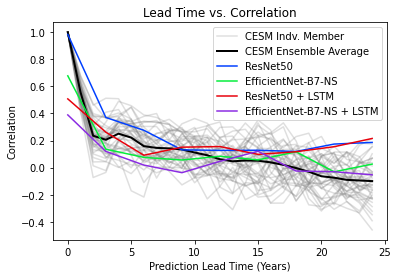

In [58]:
# Plot the Autocorrelation


fig,ax=plt.subplots(1,1,figsize=(6,4))
plt.style.use('seaborn')
plt.style.use('seaborn-bright')

for ien in range(nmembers): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

for i in range(5):
    ax.plot(leads,testcorr[i],label=expnames[i])
ax.legend(ncol=2,fontsize=9)
#ax.grid(True)
ax.set_title("Lead Time vs. Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
ax.set_ylabel("Correlation")

#plt.savefig(outpath+"LeadTime_vs_Correlation_Ablation.png",dpi=200)
plt.show()

In [13]:
# Load GRU

fn = "leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen30_leadnum24.npz"


# Load ENB7-LTSM results
fload = np.load(datpath+fn,allow_pickle=True)
print(fload.files)

for file in fload.files:
    print(file+" is of shape: "+str(fload[file].shape))

trainloss.append(fload['train_loss'])
testloss.append(fload['test_loss'])
testcorr.append(fload['test_corr'])
yvalpred.append(fload['y_pred_val'])
yvallab.append(fload['y_valdt'])

['train_loss', 'test_loss', 'test_corr', 'y_pred_val', 'y_valdt']
train_loss is of shape: (20, 9)
test_loss is of shape: (20, 9)
test_corr is of shape: (9,)
y_pred_val is of shape: (456,)
y_valdt is of shape: (456,)


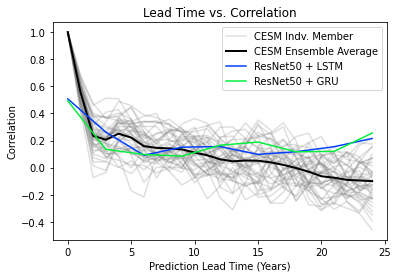

In [14]:
# Plot the Autocorrelation with GRU
 
fig,ax=plt.subplots(1,1,figsize=(6,4))
plt.style.use('seaborn-bright')

for ien in range(nmembers): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

for i in [2,5]:
    ax.plot(leads,testcorr[i],label=expnames[i])
ax.legend()
#ax.grid(True)
ax.set_title("Lead Time vs. Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
ax.set_ylabel("Correlation")

#plt.savefig(outpath+"LeadTime_vs_Correlation_Ablation_RNN.png",dpi=200)
plt.show()